# Generate Synthetic data with non-linear and coupled relationships

In [10]:
import sys
sys.path.append("../../") # if running from this folder
from matplotlib import pyplot as plt
import torch
from src.data.synthetic_temporal_causal_graph import SyntheticTCG, generate_data
from IPython.display import SVG, display
from lingam.utils import make_dot
from src.utils import get_model_device

Settings

In [11]:
N = 5     # num nodes
E = 0     # num external nodes
K = 5    # max lags
T = 300  # sequence length
n_graphs = 1
file_name = f"synthetic_N-{N}_T-{T}_K-{K}"

Function for rendering the graph.

In [12]:
def render_graph(file_name, causal_graph):
    labels = [f"N{i}" for i in range(causal_graph.num_internal_nodes)] + [f"E{i}" for i in range(causal_graph.num_external_nodes)]
    dot_graph = make_dot(causal_graph.get_causal_matrix(), labels=labels)
    dot_graph.format = 'svg'
    dot_graph.render(file_name, cleanup=True)
    display(SVG(f'{file_name}.svg'))

## Generate many causal graph structures
Iterate on this cell until you find a graph that you like. 

In [16]:
causal_graphs = [SyntheticTCG(num_internal_nodes=N, max_lags=K, min_incoming_connections=1, num_external_nodes=E, num_ext_connections=1) for _ in range(n_graphs)]

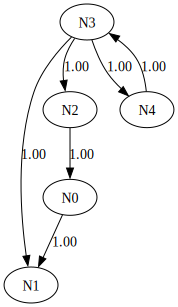

In [17]:
render_graph(file_name, causal_graphs[0])

This function initializes the non-linear functions according to the graph by training them on random data points.

In [18]:
for cg in causal_graphs:
    cg.init_functional_relationships()

Training.. Loss=0.0166: 100%|█████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 246.77it/s]


Generate synthetic data using the milestones provided. In this example, it starts with causal graph 1, changes to 2 and then changes back.

In [19]:
generated_data = []
for cg in causal_graphs:
    generated_data.append(generate_data([(0, cg)], sequence_length=T, warmup=200))

data = torch.cat([d[0] for d in generated_data], dim=0)
data_noise_adjusted = torch.cat([d[1] for d in generated_data], dim=0)
ground_truth = torch.cat([d[2].mean(dim=-1) for d in generated_data], dim=0)

Generating temporal data..: 100%|██████████████████████████████████████████████████| 501/501 [00:00<00:00, 1495.28it/s]


The mean of the data is outputted as well and can be used to evaluate the correctness of the mu predictions in variational inference.

In [20]:
print("data               :", data.size())
print("data_noise_adjusted:", data_noise_adjusted.size())
print("ground_truth       :", ground_truth.size())

data               : torch.Size([1, 5, 300])
data_noise_adjusted: torch.Size([1, 5, 300])
ground_truth       : torch.Size([1, 5, 5])


Save the data to a file.

In [21]:
path = f"{file_name}.pt"
torch.save({'name': file_name, 'data': data, 'data_noise_adjusted': data_noise_adjusted, 'ground_truth': ground_truth}, path)
print(f"Written to '{path}'!")

Written to 'synthetic_N-5_T-300_K-5.pt'!


This is the part in the data where the two causal connections change.